# Optional Homework 1: Vector Quantised - Variational AutoEncoder (VQ-VAE)

In [1]:
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
# from torchsummary import summary

import matplotlib.pyplot as plt

from model import VQVAE, UtilLSTM
from train import test

In [ ]:
# Set random seed for reproducability and dataset splitting
torch.manual_seed(42)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## Exploring Data

In [3]:
# Define image transformation
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load Fashion MNIST dataset
dataset = datasets.FashionMNIST("../data", download=True, transform=transform)
print(len(dataset))

60000


In [4]:
sample_idx = torch.randint(len(dataset), size=(1,)).item()
img, label = dataset[sample_idx]
print(img.shape)

torch.Size([1, 28, 28])


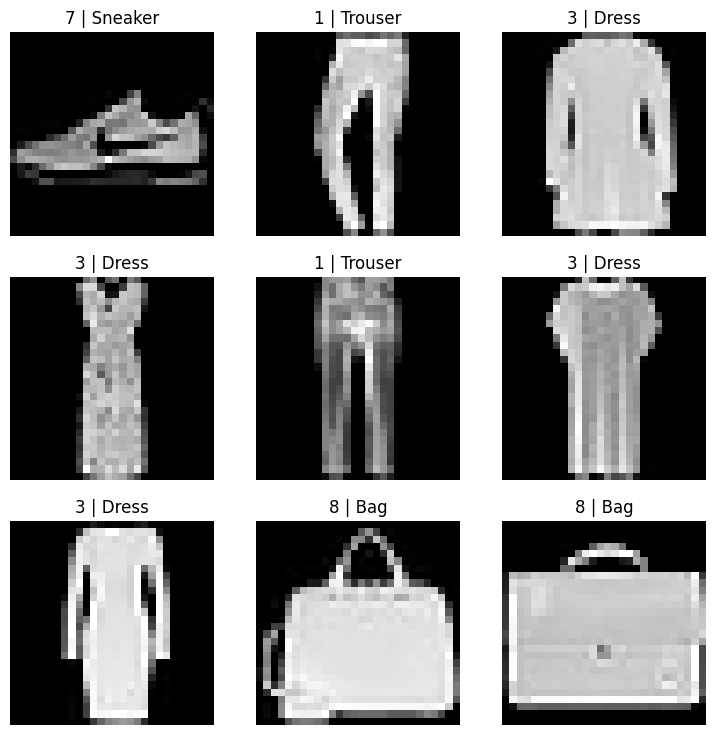

In [5]:
# From https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataloader

# Create label to class dictionary
labels_dict = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Plot images and labels
figure = plt.figure(figsize=(9, 9))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"{label} | {labels_dict[label]}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

The Fashion MNIST dataset contains 60000 grey scale images of clothes and accessories. The images are 28 by 28 pixels and are spread accross 10 classes.

## Loading Data

In [6]:
# Define training, validation and test ratios
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

# Compute training, validation and test datasets sizes
train_size = int(train_ratio * len(dataset))
validation_size = int(validation_ratio * len(dataset))
test_size = len(dataset) - train_size - validation_size

# Create training, validation and test datasets
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

In [7]:
print(f"Total dataset size: {len(dataset)}")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Total dataset size: 60000
Training dataset size: 36000
Validation dataset size: 12000
Test dataset size: 12000


In [8]:
# Create training, validation and test data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## VQ-VAE

### Creating, Training and Loading VQ-VAE

> "The encoder consists of 2 strided convolutional layers with stride 2 and window size 4 × 4, followed by two residual
3 × 3 blocks (implemented as ReLU, 3x3 conv, ReLU, 1x1 conv), all having 256 hidden units. The decoder similarly has two residual 3 × 3 blocks, followed by two transposed convolutions with stride 2 and window size 4 × 4. We use the ADAM optimiser [21 ] with learning rate 2e-4 and evaluate the performance after 250,000 steps with batch-size 128" -- [Neural Discrete Representation Learning (Arxiv)](https://arxiv.org/abs/1711.00937)

> "In this experiment we show that we can model x = 128 × 128 × 3 images by compressing them to a z = 32 × 32 × 1 discrete space (with K=512) via a purely deconvolutional p(x|z)." -- [Neural Discrete Representation Learning (Arxiv)](https://arxiv.org/abs/1711.00937)

Thanks to the technical details porvided in the VQ-VAE article and online inspiration (see `Related Links` in `README.md`), I implemented and trained a VQ-VAE (see `model.py` and `train.py`). 

In [9]:
# Instanciate VQ-VAE model
vqvae = VQVAE()

# Print model informations
# summary(vqvae, input_size=torch.Size([1, 28, 28]))

In [10]:
# Load weights
id = 245458
checkpoint = torch.load(f"train_res/{id}/checkpoint_best.pth.tar",
                        weights_only=True, map_location=torch.device("cpu"))
vqvae.load_state_dict(checkpoint["state_dict"])
vqvae = vqvae.eval().to(device)

### Running Inference and Testing

In [11]:
# Test inference
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        batch, _ = batch # Retrieve only images
        batch = batch.to(device)

        x_recon, z, quantized, loss = vqvae(batch)

        break

In [12]:
print(z.shape)
print(quantized.shape)

torch.Size([64, 256, 5, 5])
torch.Size([64, 256, 5, 5])


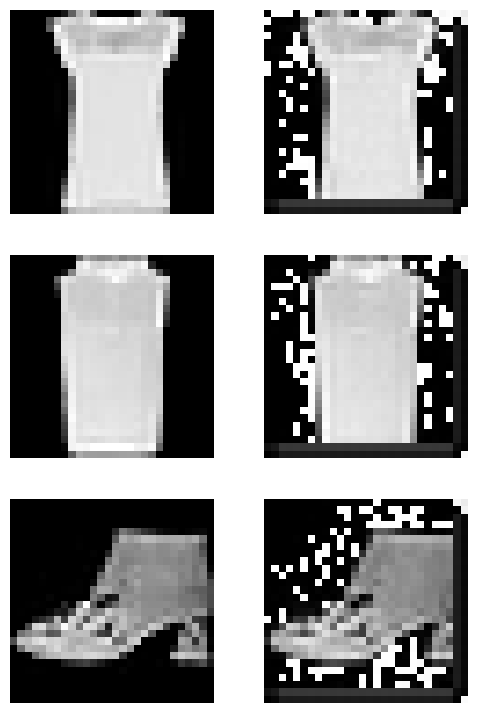

In [13]:
# Visualisation of test inference
n_samples = 3

fig, axs = plt.subplots(n_samples, 2, figsize=(6, 3*n_samples))

for i in range(n_samples):
    sample_idx = torch.randint(len(batch), size=(1,)).item()
    img = batch[sample_idx]
    img_recon = x_recon[sample_idx]

    axs[i,0].imshow(img.squeeze(), cmap="gray")
    axs[i,1].imshow(transforms.ToPILImage()(img_recon.squeeze().cpu()), cmap="gray")

    axs[i,0].axis("off")
    axs[i,1].axis("off")

Visualising the results of inference on the test dataset shows that the VQ-VAE learnt how to reconstruct images for the most part. The shape of the objects are clearly recognisable eventhough there are some errors (notably in the background). These results could certainly be improved by training the VQ-VAE for longer. However, due to time constraints, this model will be used throughout the rest of this study.

In [14]:
# test_loss = test(vqvae, test_loader)

## Generating New Images

### From Noise

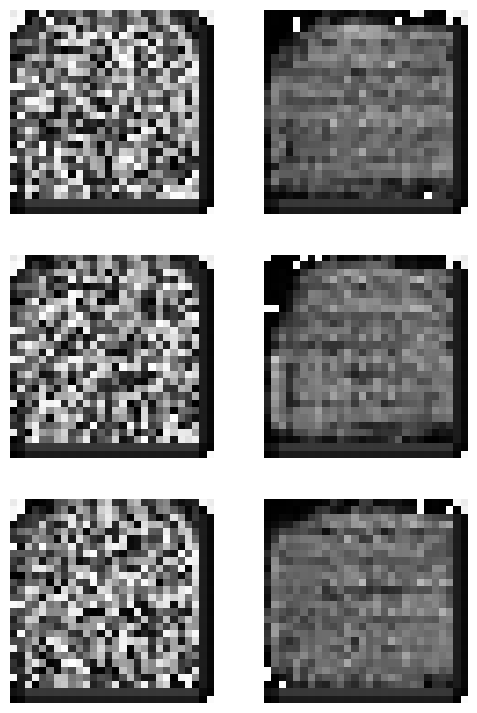

In [15]:
# Visualisation of test inference
n_samples = 3

fig, axs = plt.subplots(n_samples, 2, figsize=(6, 3*n_samples))

for i in range(n_samples):
    img_z_noisy = torch.rand(1, 256, 5, 5)
    img_gen_0 = vqvae._decoder(img_z_noisy)

    img_q, _ = vqvae._vq(img_z_noisy)
    img_gen_1 = vqvae._decoder(img_q)

    axs[i, 0].imshow(transforms.ToPILImage()(img_gen_0.squeeze().cpu()), cmap="gray")
    axs[i, 1].imshow(transforms.ToPILImage()(img_gen_1.squeeze().cpu()), cmap="gray")

    axs[i, 0].axis("off")
    axs[i, 1].axis("off")

Contrary to VAE, generating new samples from noise does not work. The above plot shows on the left column images generated by running the VQ-VAE's decoder on noise and on the right column images generated by quantising the same noise before infering with the decoder. This is due to the discrete nature of the VQ-VAE's latent space. Contrary to VAE which latent space is continuous, allowing to consider random noise as the latent represeentation of an "meaningful" input, VQ-VAE map each feature in the latent space to the closest entry in the codebook. By feeding random noise into the model, there's no guarantee that the resulting latent codes will match well with the learned codebook.

### Using the Encoder

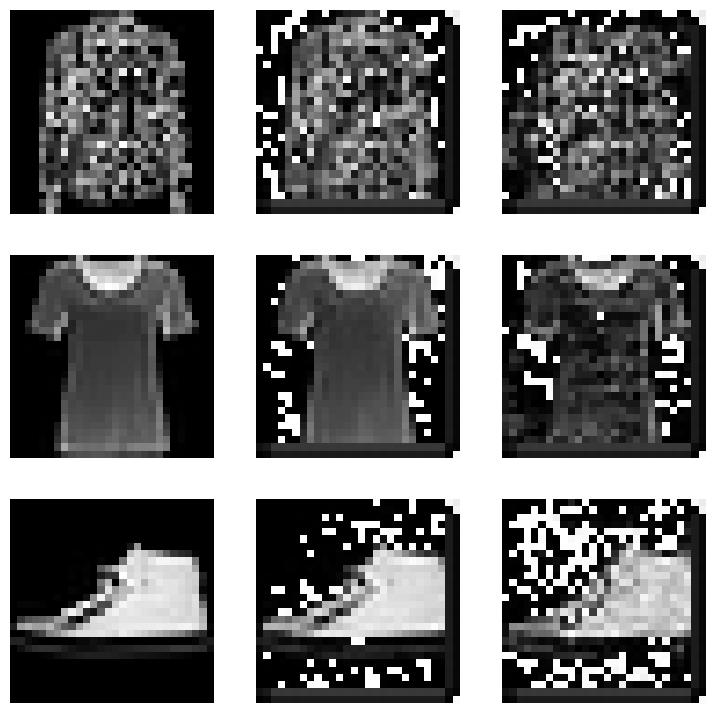

In [16]:
# Visualisation of test inference
n_samples = 3

fig, axs = plt.subplots(n_samples, 3, figsize=(9, 3*n_samples))

for i in range(n_samples):
    sample_idx = torch.randint(len(batch), size=(1,)).item()
    img = batch[sample_idx]
    img_z = z[sample_idx]
    img_q = quantized[sample_idx]
    img_recon = x_recon[sample_idx]

    img_z_noisy = img_z + torch.rand(256, 5, 5)
    img_z_noisy = torch.reshape(img_z_noisy, (-1, 256, 5, 5))
    img_tmp, _ = vqvae._vq(img_z_noisy)
    img_gen = vqvae._decoder(img_tmp)

    axs[i,0].imshow(img.squeeze(), cmap="gray")
    axs[i,1].imshow(transforms.ToPILImage()(img_recon.squeeze().cpu()), cmap="gray")
    axs[i,2].imshow(transforms.ToPILImage()(img_gen.squeeze().cpu()), cmap="gray")

    axs[i,0].axis("off")
    axs[i,1].axis("off")
    axs[i,2].axis("off")

This plot shows on each row: an image from the dataset, its reconstruction with the VQ-VAE and the image generated by adding noise to the latent representation of the image from the dataset. Eventhgough there are imperctions in both reconstructions, it is clear that they are not the same. Adding some noise allows to modify the latent representation just enough so it matches with the learned codebook but induces a different quantisation and generate a new image that looks like one from the dataset. This methods seems to work but is highly unsatisfactory as the encoder (ie: the posterior) is required to generate new data...

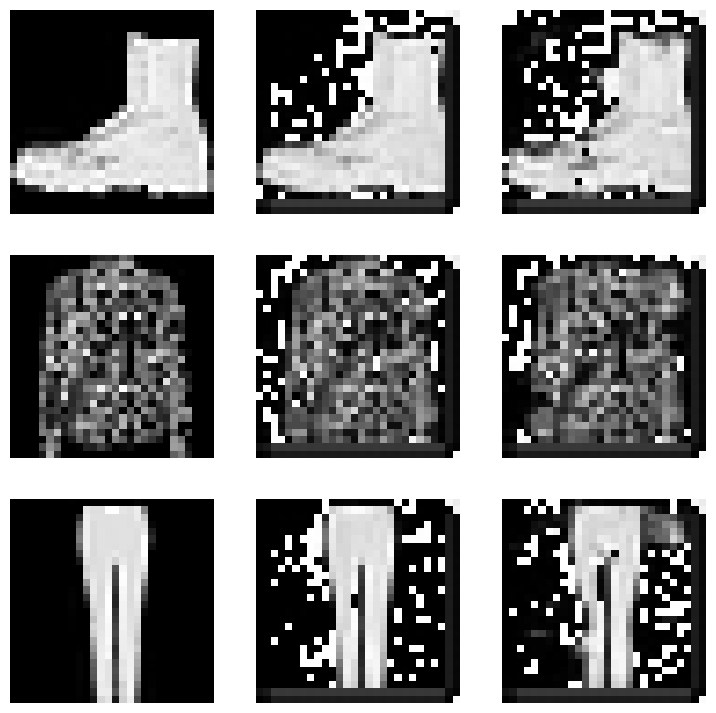

In [17]:
# Visualisation of test inference
n_samples = 3
n_changes = 10
idx_src = torch.randint(len(vqvae._vq._embedding.weight), size=(n_changes,))
# idx_dest = torch.randint(len(flat_img_q), size=(n_changes,))
idx_dest = torch.randint(100, size=(n_changes,))

fig, axs = plt.subplots(n_samples, 3, figsize=(9, 3*n_samples))

for i in range(n_samples):
    sample_idx = torch.randint(len(batch), size=(1,)).item()
    img = batch[sample_idx]
    img_z = z[sample_idx]
    img_q = quantized[sample_idx]
    img_recon = x_recon[sample_idx]

    # Convert quantized from [B,C,H,W] to [B,H,W,C]
    img_q = torch.reshape(img_q, (-1, 256, 5, 5))
    img_q = img_q.permute(0, 2, 3, 1).contiguous()
    img_q_shape = img_q.shape

    # Flatten quantized
    flat_img_q = img_q.view(-1, vqvae._vq._embedding_dim)
    # print(len(flat_img_q))

    # Modify quantized
    for j in range(n_changes):
        flat_img_q[idx_dest[j]] = vqvae._vq._embedding.weight[idx_src[j]]

    # Reshape quantized
    img_q = flat_img_q.view(img_q_shape)

    # Convert quantized from [B,H,W,C] to [B,C,H,W]
    img_q = img_q.permute(0, 3, 1, 2).contiguous()

    img_gen = vqvae._decoder(img_q)

    axs[i,0].imshow(img.squeeze(), cmap="gray")
    axs[i,1].imshow(transforms.ToPILImage()(img_recon.squeeze().cpu()), cmap="gray")
    axs[i,2].imshow(transforms.ToPILImage()(img_gen.squeeze().cpu()), cmap="gray")

    axs[i,0].axis("off")
    axs[i,1].axis("off")
    axs[i,2].axis("off")

Here is the comparaison of an image from the dataset, its reconstruction with the VQ-VAE and its reconstruction after swapping some embeddings from the quantized latent representation. For the same reasons as before, this technique allows to generate new images. I tried this techniquue because I thought I would be able to see the knowledge contained in the model's embeddings. I was not able to draw any conclusion on that topic with these results.

### Generating Images for Real

### LSTM

In [ ]:
# Instanciate LSTM model
lstm = UtilLSTM().to(device)

# Train LSTM model
train_lstm(lstm, train_loader, vqvae, epochs=1)

# Save LSTM model
torch.save(model.state_dict(), "lstm.pth.tar")

Epoch [1/1], Step [1/563], Loss: 0.0959


In [ ]:
# Load LSTM model
lstm.load_state_dict(torch.load("lstm.pth.tar", weights_only=True))

#### New Images

In [ ]:
# Function to generate new latent sequences using LSTM
def generate_latent_sequence(lstm, seq_len=25, latent_size=256, batch_size=1):
    # Start with a random latent vector for the first time step
    initial_input = torch.randn(batch_size, 1, latent_size).to(device) # Shape: [batch_size, 1, latent_size]
    
    # Generate a sequence of latent codes
    lstm_output = []
    hidden = None
    for _ in range(seq_len):
        output, hidden = lstm.lstm(initial_input, hidden)
        latent_code = lstm.fc(output) # Predict the next latent code
        lstm_output.append(latent_code)
        initial_input = latent_code  # Use the predicted latent code as input for the next time step
    
    # Convert list to tensor and reshape for decoder input (batch_size, seq_len, 256)
    lstm_output = torch.stack(lstm_output, dim=1)  # Shape: [batch_size, seq_len, 256]
    return lstm_output

# Function to decode latent codes into images using VQ-VAE decoder
def decode_latent_codes(vqvae_model, latent_codes, batch_size=1):
    latent_codes = latent_codes.view(-1, latent_codes.size(2), 5, 5) # Shape: [batch_size, 256, 5, 5]
    decoded_images = vqvae_model.decoder(latent_codes)
    return decoded_images

# Generate new images
def generate_images(lstm_model, vqvae_model, num_images=5, seq_len=25):
    lstm_model.eval() # Set LSTM to evaluation mode
    vqvae_model.eval() # Set VQ-VAE to evaluation mode

    with torch.no_grad():
        for i in range(num_images):
            # Generate a latent sequence from the LSTM
            latent_sequence = generate_latent_sequence(lstm_model, seq_len=seq_len, batch_size=1)

            # Decode the generated latent sequence into an image
            generated_image = decode_latent_codes(vqvae_model, latent_sequence, batch_size=1)

            # Plot the generated image
            plt.figure(figsize=(3, 3))
            plt.imshow(generated_image.squeeze().cpu().numpy().transpose(1, 2, 0))  # Convert to HWC
            plt.axis('off')
            plt.show()

# Example usage: Generate 5 new images using the trained models
generate_images(lstm, vqvae, num_images=5, seq_len=25)